# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import cv2
import tools.davinci as dv
import tools.metrics as ms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping # type: ignore
from keras.layers import Dense, Dropout # type: ignore
from keras.models import Sequential # type: ignore
from keras.regularizers import l2 # type: ignore
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import davies_bouldin_score, silhouette_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
from tools.detector import PoseLandmarkerDetector

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
%%script True  # Comment this line to run the code below

extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

extractor.extract_frames()

### Data Augmentation

Data augmentation will help to increase the dataset in size, adding robustness and improvng the accuracy of the model. For data augmentation, the following techniques will be applied for each image:
- Vertical flipping
- Horizontal flipping
- Random rotations (from 30 to 330 degrees)

In [4]:
%%script True  # Comment this line to run the code below

extractor.flip_frames(target="assets/frames_vflip", axis=0)
extractor.flip_frames(target="assets/frames_hflip", axis=1)
extractor.random_rotate_frames(target="assets/frames_rotated", minr=30, maxr=330)

### Skeleton Joints Extraction

To extract keypoints, the PoseLandmarker will be used. It is not only estimates the pose of a human, but also depth, which can help to compute real distances, and not only projections. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

In [3]:
detector = PoseLandmarkerDetector("models/pose_landmarker_full.task")
category = "keypoints_plm_full"

I0000 00:00:1719413724.686134 6214681 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1719413724.754268 6214908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719413724.758901 6214909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
I0000 00:00:1719413724.792529 6214681 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro

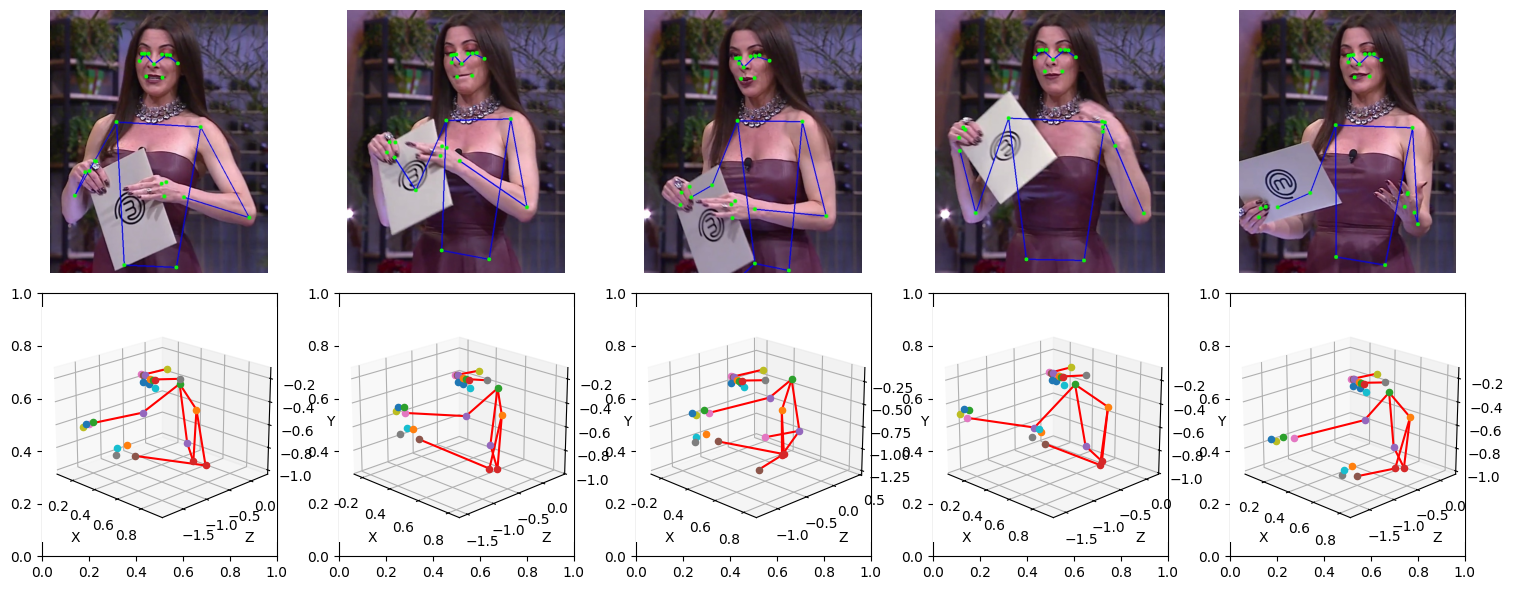

In [4]:
image_paths = [
    "assets/frames/aJKL0ahn1Dk_0.jpg",
    "assets/frames/aJKL0ahn1Dk_5.jpg",
    "assets/frames/aJKL0ahn1Dk_10.jpg",
    "assets/frames/aJKL0ahn1Dk_15.jpg",
    "assets/frames/aJKL0ahn1Dk_20.jpg"
]

fig, axes = plt.subplots(2, len(image_paths), figsize=(15, 6), gridspec_kw={'height_ratios': [1, 1]})

for i, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    result = detector.detect(image_path)
    result_aligned = detector.detect(image_path, align=False)
    img_bytes = dv.draw(result)
    
    img_np_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(img_np_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[0][i].imshow(img)
    axes[0][i].axis("off")

    ax = fig.add_subplot(2, len(image_paths), len(image_paths) + i + 1, projection='3d')
    dv.visualize(result_aligned, ax)

plt.tight_layout()
plt.show()

In [7]:
%%script True  # Comment this line to run the code below

def apply_model(model, df, target, output_csv):
    keypoints = model.detect_multi(df, target, depth=True, align=True)
    result_df = pd.concat(keypoints, axis=1, ignore_index=True).T
    result_df.to_csv(output_csv, index=False)

apply_model(
    detector,
    df,
    "assets/frames",
    f"assets/annotations/{category}.csv"
)

plm_df = pd.read_csv(f"assets/annotations/{category}.csv")
plm_df.head()

### Combine all DataFrames

In [5]:
plm_df = pd.read_csv(f"assets/annotations/{category}.csv")
combined_df = pd.concat([df, plm_df], axis=1).reset_index(drop=True)
combined_df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,left_hiel_Z,right_hiel_X,right_hiel_Y,right_hiel_Z,left_teen_X,left_teen_Y,left_teen_Z,right_teen_X,right_teen_Y,right_teen_Z
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,1.188313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,1.208457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,1.356732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,1.273436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,0.760523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

According to [Wei Tang](https://www.mdpi.com/1424-8220/22/11/4245), frames in which body parts were occluded or lost were excluded from further analysis, because the skeletons in these frames could not be detected correctly using the current 2D pose estimation algorithm. The necessary body parts will be determined as torso, left and right hands. The position of head and legs will be ommited.

In [6]:
columns_drop = combined_df.columns[combined_df.columns.get_loc('right_hip_Z')+1:]
cleaned_df = combined_df.drop(columns=columns_drop)

body_parts = cleaned_df.columns[cleaned_df.columns.get_loc('right_ear_Z')+1:]
cleaned_df = cleaned_df.dropna(subset=body_parts, how='all')

cleaned_df = cleaned_df.reset_index(drop=True)
interpolate_columns = cleaned_df.columns[cleaned_df.columns.get_loc('Person Id')+1:]
cleaned_df = ms.interpolate(cleaned_df, interpolate_columns)

print("cleaned_df shape:", cleaned_df.shape)
cleaned_df.head()

cleaned_df shape: (3675, 84)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,left_f3_Z,right_f3_X,right_f3_Y,right_f3_Z,left_hip_X,left_hip_Y,left_hip_Z,right_hip_X,right_hip_Y,right_hip_Z
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,1.188313,...,-0.206469,1.454195,0.558844,-0.466030,0.486243,0.967889,0.422609,-0.058462,0.967889,0.422609
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,1.208457,...,-0.114960,1.462542,0.601251,-0.373679,0.477585,0.970022,0.450328,-0.069194,0.970022,0.450328
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,1.356732,...,-0.305752,1.754588,0.573079,-0.744054,0.495469,0.975558,0.434683,0.031373,0.975558,0.434683
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,1.273436,...,-0.327143,1.549114,0.613047,-0.554211,0.495414,0.967415,0.438220,-0.028613,0.967415,0.438220
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,0.760523,...,-0.058205,1.113446,0.501809,-0.329603,0.509818,0.943826,0.455250,0.001599,0.943826,0.455250


## Step 2: Feature Extraction

#### Segment Normalization

Before clustering, we needs to ensure that all segments have identical size:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [7]:
segments = ms.segment(cleaned_df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [ms.normalize_segment(segment, target_size=5) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

norm_segments = ms.segment(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 326
Original (first 5): [(0, 56), (57, 70), (71, 83), (84, 98), (99, 110)]
Total number of normalized segments: 326
Normalized (first 5): [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24)]


#### Emotion Labeling

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a particular emotion. In that case for each segment the number of each emotion will be calculated (e.g. <code>[[Happy, Sad, Happy], [Happy, Happy, Angry]]</code> will be converted to <code>{Happy: 4, Sad: 1, Angry: 1, Fear: 0, ...}</code>).

In [8]:
emotion_count = norm_segments[0].count_emotions()
print("Emotion count:", emotion_count)

Emotion count: {'Happy': 13, 'Sad': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Anger': 0, 'Neutral': 2}


## Step 3: Clustering

### Prepare data to cluster

In [9]:
features = {}
pairs = ["nose", "left_shoulder", 
         "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"]

for i in range(len(norm_segments)):
    feature = norm_segments[i].get_vectors(pairs=pairs)
    features[f"s_{i}"] = feature

features_df = pd.DataFrame.from_dict(features, orient='index')
print(features_df.shape)
features_df.head()

(326, 876)


,Label,d_nose_left_reye_0,d_nose_left_reye_1,d_nose_left_reye_2,d_nose_left_reye_3,d_nose_left_reye_4,d_nose_left_eye_0,d_nose_left_eye_1,d_nose_left_eye_2,d_nose_left_eye_3,...,d_right_wrist_right_hip_0,d_right_wrist_right_hip_1,d_right_wrist_right_hip_2,d_right_wrist_right_hip_3,d_right_wrist_right_hip_4,a_right_wrist_hips_0,a_right_wrist_hips_1,a_right_wrist_hips_2,a_right_wrist_hips_3,a_right_wrist_hips_4
s_0,Happy,0.082590,0.069682,0.084097,0.070288,0.083366,0.093502,0.082971,0.090949,0.087286,...,1.770276,1.803062,1.156275,0.628337,1.170935,2.635480,2.497703,2.425007,1.986246,2.348199
s_1,Fear,0.073293,0.053975,0.034811,0.029567,0.054217,0.071580,0.054793,0.035460,0.029878,...,0.389799,0.476929,0.621197,0.707523,0.490506,1.244211,1.349219,0.835853,1.997929,1.123775
s_2,Happy,0.076867,0.076171,0.062143,0.062613,0.070798,0.075955,0.075646,0.068011,0.067146,...,1.602126,1.497097,0.702986,1.385991,0.555637,0.539433,0.776755,1.815781,2.203400,1.395152
s_3,Neutral,0.074700,0.066574,0.065717,0.066048,0.149250,0.074591,0.066070,0.065327,0.065816,...,0.199696,0.296469,0.313723,0.380454,3.455988,1.533945,1.376705,1.266262,1.145410,2.653345
s_4,Happy,0.051273,0.052767,0.067467,0.076566,0.050435,0.052331,0.052344,0.066447,0.075609,...,0.434418,0.608672,0.500550,0.465466,0.543975,1.019967,1.255320,1.329457,1.133994,1.019232


### Removing underrepresented classes

In [10]:
label_counts = features_df['Label'].value_counts()
print("Original label counts:")
print(label_counts)

labels_to_remove = ["Sad", "Surprise", "Disgust", "Fear"]
trunc_features_df = features_df[~features_df['Label'].isin(labels_to_remove)]
label_counts = trunc_features_df['Label'].value_counts()
print("\nAfter removing some labels:")
print(label_counts)

Original label counts:
Label
Neutral     161
Happy        87
Anger        42
Sad          11
Surprise     10
Disgust       8
Fear          7
Name: count, dtype: int64

After removing some labels:
Label
Neutral    161
Happy       87
Anger       42
Name: count, dtype: int64


### Hierarchical Clustering

Silhouette Score: 0.13602979846661453
Davies-Bouldin Index: 1.610737807702508
2    140
1    131
5     23
6     20
3      8
0      3
4      1
Name: count, dtype: int64


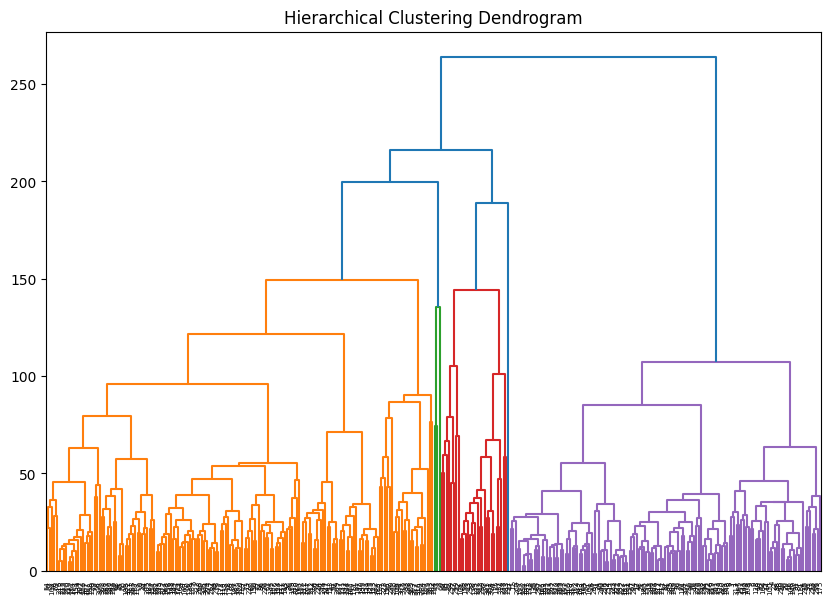

In [55]:
scaler = StandardScaler()
encoder = LabelEncoder()

labels = features_df['Label']
encoded_labels = encoder.fit_transform(labels)

data = features_df.drop(columns=['Label'])
scaled_data = scaler.fit_transform(data)

cluster = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(scaled_data)
data['Clusters'] = cluster_labels

silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')
davies_bouldin = davies_bouldin_score(scaled_data, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')

cluster_counts = pd.Series(cluster_labels).value_counts()
print(cluster_counts)

linked = linkage(scaled_data, metric="euclidean", method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Applying PCA and Plotting the Results

/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_42972/2271944429.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = labels[i]


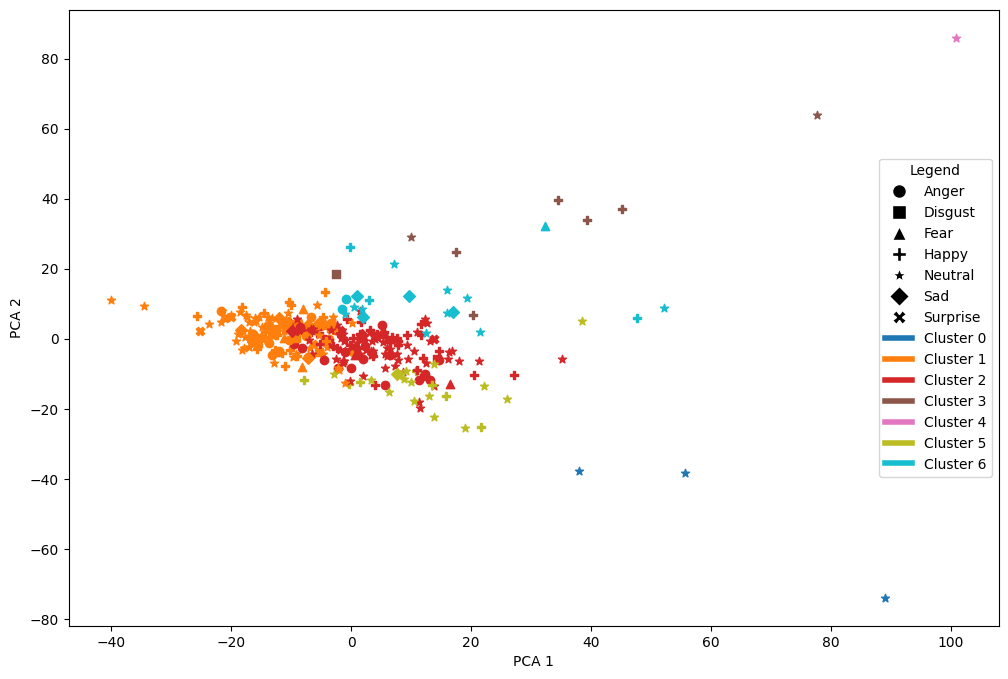

In [56]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

unique_labels = np.unique(labels)
unique_clusters = np.unique(cluster_labels)

shapes = ['o', 's', '^', 'P', '*', 'D', 'X']
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

shape_map = {label: shapes[i % len(shapes)] for i, label in enumerate(unique_labels)}
color_map = {cluster: colors[i % len(colors)] for i, cluster in enumerate(unique_clusters)}

fig, ax = plt.subplots(figsize=(12, 8))
for i, point in enumerate(pca_result):
    label = labels[i]
    cluster = cluster_labels[i]
    shape = shape_map[label]
    color = color_map[cluster]
    ax.scatter(point[0], point[1], marker=shape, color=color, label=f'{label}, Cluster {cluster}')

legend_shapes = [plt.Line2D([0], [0], color='w', marker=shape, markersize=10, markerfacecolor='k') for shape in shapes[:len(unique_labels)]]
legend_colors = [plt.Line2D([0], [0], color=color, lw=4) for color in colors[:len(unique_clusters)]]
handles = legend_shapes + legend_colors
labels = list(unique_labels) + [f'Cluster {i}' for i in unique_clusters]

ax.legend(handles, labels, title="Legend")
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.show()

## Step 4: Classification

In [13]:
RANDOM_STATE = 42
NUM_CLASSES = 3
TEST_SIZE = 0.2

scaler = StandardScaler()
label_encoder = LabelEncoder()

X = trunc_features_df.drop(['Label'], axis=1)
y = trunc_features_df['Label']
X_scaled = scaler.fit_transform(X)
labels = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("X_resampled:", X_resampled.shape, "y_resampled:", y_resampled.shape)

X_train: (232, 875) X_test: (58, 875)
X_resampled: (322, 875) y_resampled: (322,)


### Support Vector Machines (SVM)

#### Single Example

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, k

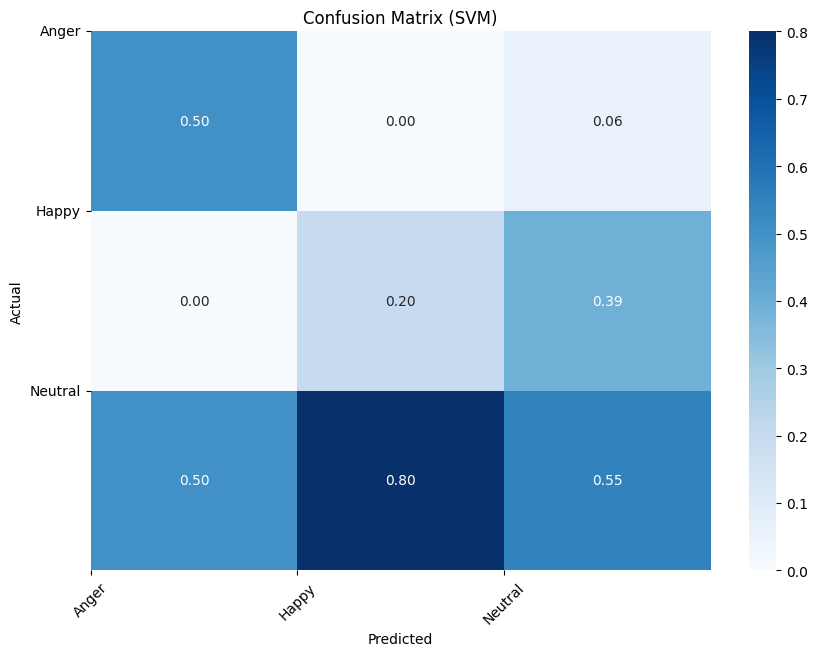

In [14]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly']
}

svm = SVC(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)
svm_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred, average='weighted')
recall = recall_score(y_test, svm_pred, average='weighted')
f1 = f1_score(y_test, svm_pred, average='weighted')

print("Best parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, svm_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=0)

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (SVM)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

#### Distribution Example

Progress: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]
/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_42972/367984903.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accuracies, label='Accuracy', color='blue', shade=True)
/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_42972/367984903.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(f1_scores, label='F1-Score', color='orange', shade=True)


Mean accuracy: 0.5586206896551724
Mean F1-Score: 0.45938398904439187


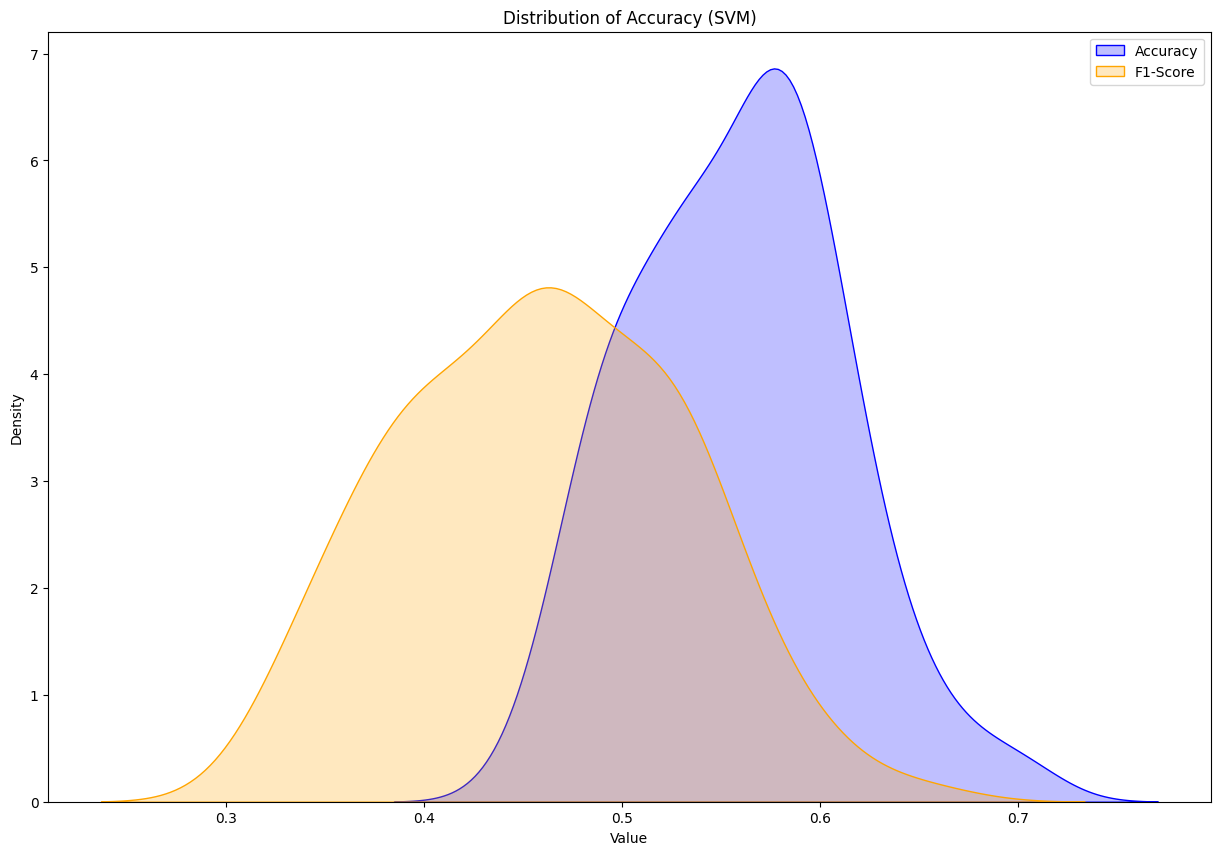

In [15]:
accuracies = []
f1_scores = []

for RANDOM_STATE in tqdm(range(100), desc="Progress"):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    svm = SVC(random_state=RANDOM_STATE)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
    grid_search.fit(X_resampled, y_resampled)
    svm_pred = grid_search.predict(X_test)

    accuracy = accuracy_score(y_test, svm_pred)
    accuracies.append(accuracy)

    f1 = f1_score(y_test, svm_pred, average='weighted')
    f1_scores.append(f1)

print("Mean accuracy:", np.mean(accuracies))
print("Mean F1-Score:", np.mean(f1_scores))

plt.figure(figsize=(15, 10))
sns.kdeplot(accuracies, label='Accuracy', color='blue', shade=True)
sns.kdeplot(f1_scores, label='F1-Score', color='orange', shade=True)
plt.title('Distribution of Accuracy (SVM)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

### Bayessian Naive Classifier

#### Single Example

Best parameters: {'var_smoothing': 0.004328761281083057}
Accuracy: 24.14%
Precision: 0.40
Recall: 0.24
F1-Score: 0.29


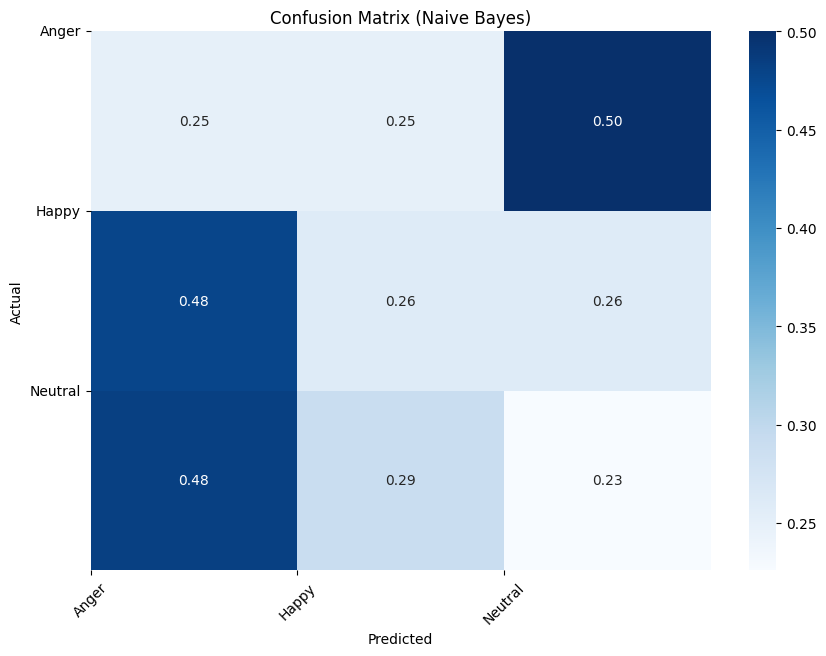

In [16]:
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

gnb = GaussianNB()
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(X_resampled, y_resampled)
gnb_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, gnb_pred)
precision = precision_score(y_test, gnb_pred, average='weighted')
recall = recall_score(y_test, gnb_pred, average='weighted')
f1 = f1_score(y_test, gnb_pred, average='weighted')

print("Best parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, gnb_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Naive Bayes)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

#### Distribution Example

Progress: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_42972/3863320327.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accuracies, label='Accuracy', color='blue', shade=True)
/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_42972/3863320327.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(f1_scores, label='F1-Score', color='orange', shade=True)


Mean accuracy: 0.29258620689655174
Mean F1-Score: 0.29366290627450115


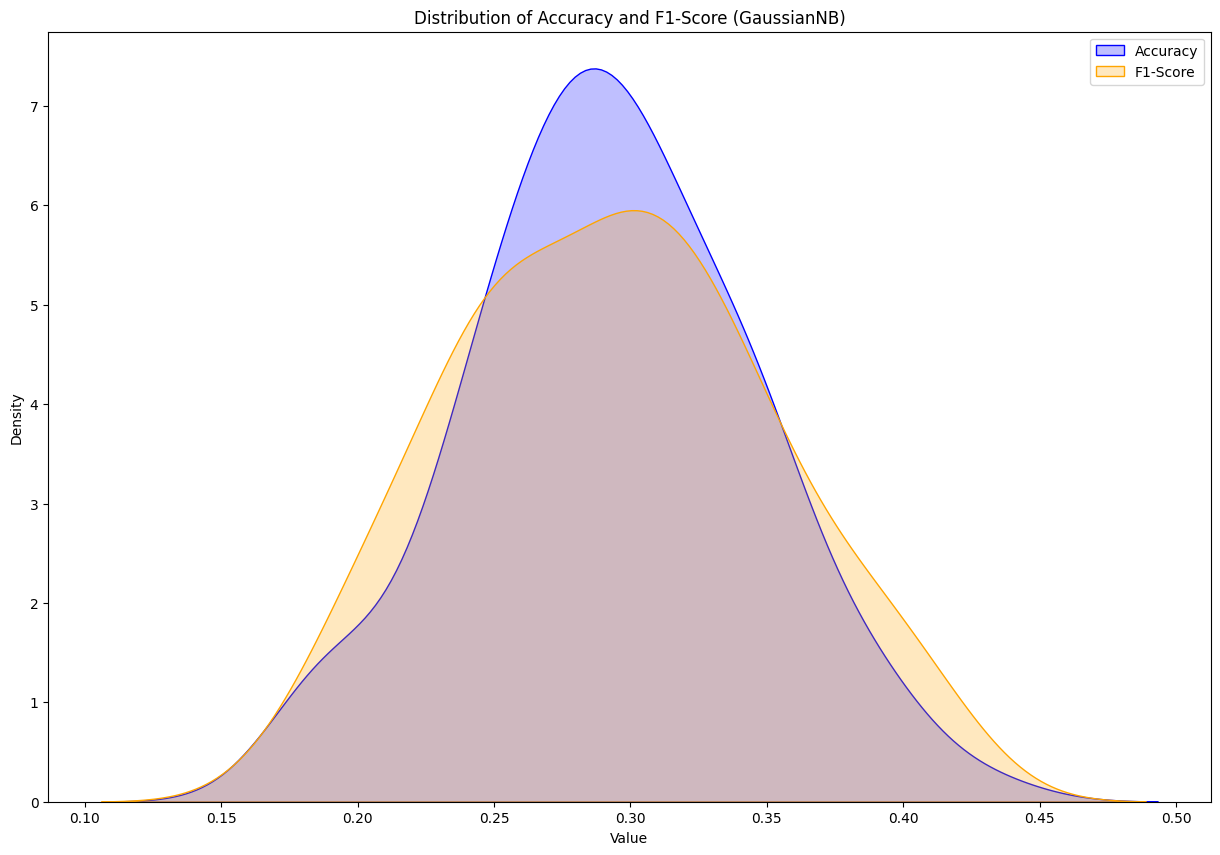

In [17]:
accuracies = []
f1_scores = []

for RANDOM_STATE in tqdm(range(100), desc="Progress"):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    gnb = GaussianNB()
    grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
    grid_search.fit(X_resampled, y_resampled)
    gnb_pred = grid_search.predict(X_test)

    accuracy = accuracy_score(y_test, gnb_pred)
    accuracies.append(accuracy)

    f1 = f1_score(y_test, gnb_pred, average='weighted')
    f1_scores.append(f1)

print("Mean accuracy:", np.mean(accuracies))
print("Mean F1-Score:", np.mean(f1_scores))

plt.figure(figsize=(15, 10))
sns.kdeplot(accuracies, label='Accuracy', color='blue', shade=True)
sns.kdeplot(f1_scores, label='F1-Score', color='orange', shade=True)
plt.title('Distribution of Accuracy and F1-Score (GaussianNB)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

### Random Forest

#### Single Example

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 55.17%
Precision: 0.61
Recall: 0.55
F1-Score: 0.47


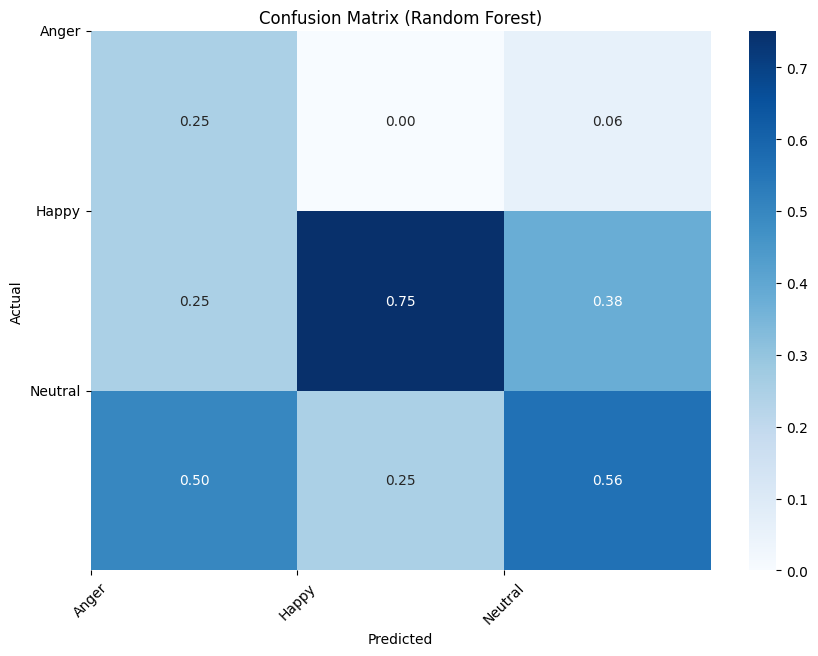

In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(X_resampled, y_resampled)
rf_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test, rf_pred, average='weighted')
recall = recall_score(y_test, rf_pred, average='weighted')
f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"Best parameters for Random Forest:", grid_search.best_params_)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, rf_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=0)

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Random Forest)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

#### Distribution Example

Progress: 100%|██████████| 100/100 [43:00<00:00, 25.81s/it]  
/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_30288/202600948.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accuracies, label='Accuracy', color='blue', shade=True)
/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_30288/202600948.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(f1_scores, label='F1-Score', color='orange', shade=True)


Mean accuracy: 0.5479310344827586
Mean F1-Score: 0.4124726974467025


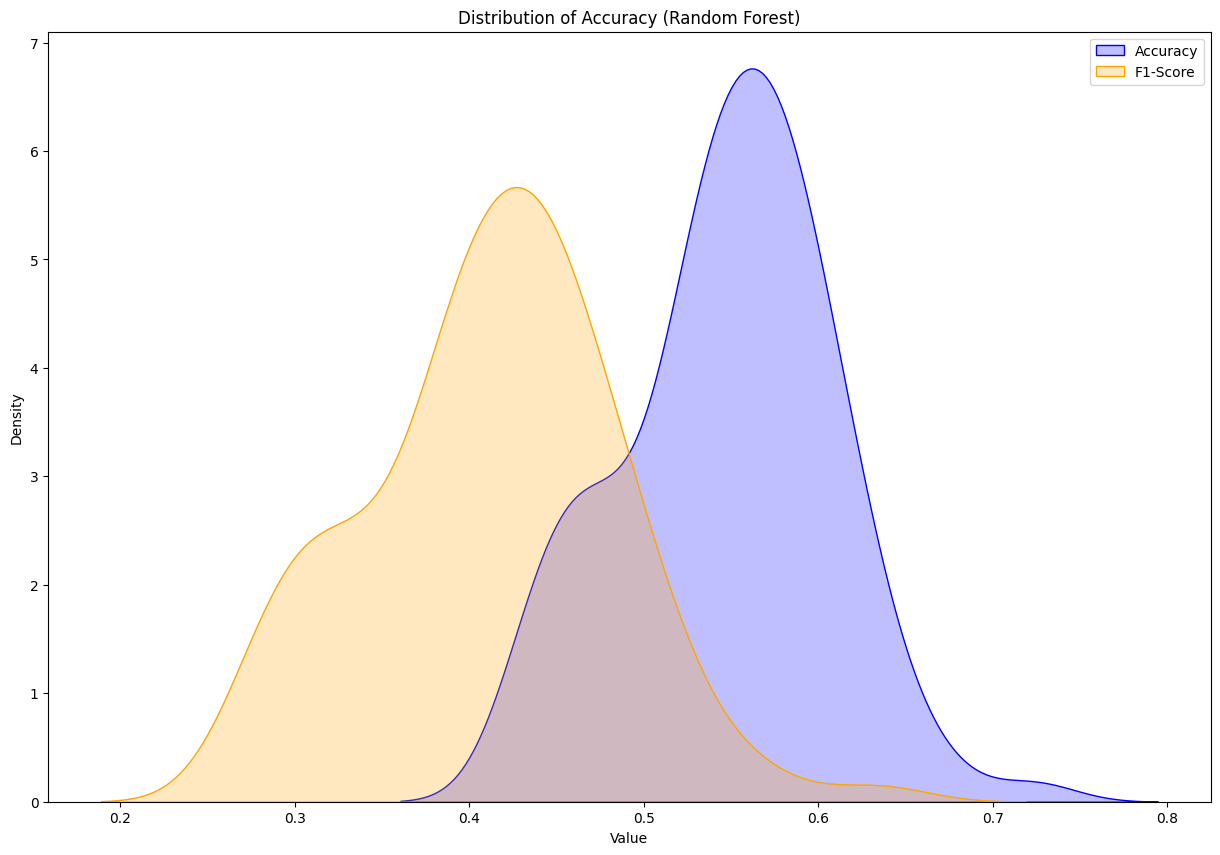

In [21]:
# accuracies = []
# f1_scores = []

# for RANDOM_STATE in tqdm(range(100), desc="Progress"):
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
#     smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
#     X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#     rf = RandomForestClassifier(random_state=RANDOM_STATE)
#     grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
#     grid_search.fit(X_resampled, y_resampled)
#     rf_pred = grid_search.predict(X_test)

#     accuracy = accuracy_score(y_test, svm_pred)
#     accuracies.append(accuracy)

#     f1 = f1_score(y_test, svm_pred, average='weighted')
#     f1_scores.append(f1)

# print("Mean accuracy:", np.mean(accuracies))
# print("Mean F1-Score:", np.mean(f1_scores))

# plt.figure(figsize=(15, 10))
# sns.kdeplot(accuracies, label='Accuracy', color='blue', shade=True)
# sns.kdeplot(f1_scores, label='F1-Score', color='orange', shade=True)
# plt.title('Distribution of Accuracy (Random Forest)')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()
# plt.show()

### Neural Network

#### Single Example

In [22]:
# EPOCHS = 100
# L2_REG = 0.01

# input_shape = X_train.shape[1]
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(L2_REG)))
# model.add(Dropout(0.5))
# model.add(Dense(35, activation='relu', kernel_regularizer=l2(L2_REG)))
# model.add(Dense(NUM_CLASSES, activation='softmax'))

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])
# history = model.fit(X_resampled, y_resampled, epochs=EPOCHS, validation_split=0.1, batch_size=32, callbacks=[early_stopping])
# svm_pred = np.argmax(model.predict(X_test), axis=1)

# actual_epochs = len(history.history['loss'])
# if actual_epochs < EPOCHS:
#     print(f"Early stopping activated after {actual_epochs} epochs.")
# else:
#     print("Training completed without early stopping.")

# test_loss, test_acc = model.evaluate(X_test, y_test)
# precision = precision_score(y_test, svm_pred, average='weighted')
# recall = recall_score(y_test, svm_pred, average='weighted')
# f1 = f1_score(y_test, svm_pred, average='weighted')

# print(f"Accuracy: {test_acc * 100:.2f}%")
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

# cm = confusion_matrix(y_test, svm_pred)
# cm_normalized = cm.astype('float') / cm.sum(axis=0)

# plt.figure(figsize=(10,7))
# sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix (Neural Network)')
# plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
# plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
# plt.show()

#### Distribution Example

In [23]:
# NUM_CLASSES = 3
# TEST_SIZE = 0.2
# EPOCHS = 100
# L2_REG = 0.01

# scaler = StandardScaler()
# label_encoder = LabelEncoder()

# X = trunc_features_df.drop(['Label'], axis=1)
# y = trunc_features_df['Label']
# X_scaled = scaler.fit_transform(X)
# labels = label_encoder.fit_transform(y)

# accuracies = []
# f1_scores = []

# for RANDOM_STATE in tqdm(range(100), desc="Progress"):
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
#     smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
#     X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
#     input_shape = X_resampled.shape[1]
#     early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
    
#     model = Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(L2_REG)))
#     model.add(Dropout(0.5))
#     model.add(Dense(35, activation='relu', kernel_regularizer=l2(L2_REG)))
#     model.add(Dense(NUM_CLASSES, activation='softmax'))
    
#     model.compile(optimizer='adam',
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   metrics=['accuracy'])
#     history = model.fit(X_resampled, y_resampled, epochs=EPOCHS, validation_split=0.1, batch_size=32, callbacks=[early_stopping], verbose=0)
    
#     nn_pred = np.argmax(model.predict(X_test), axis=1)
    
#     # actual_epochs = len(history.history['loss'])
#     # if actual_epochs < EPOCHS:
#     #     print(f"Early stopping activated after {actual_epochs} epochs.")
#     # else:
#     #     print("Training completed without early stopping.")
    
#     accuracy = accuracy_score(y_test, nn_pred)
#     accuracies.append(accuracy)

#     f1 = f1_score(y_test, nn_pred, average='weighted')
#     f1_scores.append(f1)
    
#     # test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
#     # precision = precision_score(y_test, nn_pred, average='weighted')
#     # recall = recall_score(y_test, nn_pred, average='weighted')
#     # f1 = f1_score(y_test, nn_pred, average='weighted')



# # # Optionally, you can print the mean and standard deviation of accuracies
# print("Mean accuracy:", np.mean(accuracies))
# print("Mean F1-Score:", np.mean(f1_scores))

# plt.figure(figsize=(10, 6))
# sns.histplot(accuracies, kde=True, bins=10)
# plt.title('Distribution of Accuracy (Neural Network)')
# plt.xlabel('Accuracy')
# plt.ylabel('Frequency')
# plt.show()